<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h3><center>Andrey Shestakov (<a href="mailto:avshestakov@hse.ru">avshestakov@hse.ru</a>)</center></h3>
<hr>
<h2><center>Regularization in linear models.</center></h2>
<h2><center>Linear classification. Logistic Regression<sup><a href="#fn1" id="ref1">1</a></sup></center></h2>



<sup id="fn1">1. Some materials are taken from <a href="http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%92.%D0%92.%D0%9A%D0%B8%D1%82%D0%BE%D0%B2%29">machine learning course of Victor Kitov</a></sup>

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print(u'Так надо')
    
import warnings
warnings.filterwarnings('ignore')

## Wisdom of the day
### Overfitting = Death


<center><img src='img/overfit-death.jpeg'></center>

# Let's recall previous lecture

* Linear regression
    * linear dependence between target features and predictors

$$f(x_{n}, \beta) = \hat{y}_{n} = \beta_0 + \beta_1x_{n}^1 + \dots$$

* Optimize Ordinary Least Squares
* Solution can be found 
    * analytically 
    * with gradient descent

In [3]:
df_auto = pd.read_csv('./data/accord_sedan_training.csv')


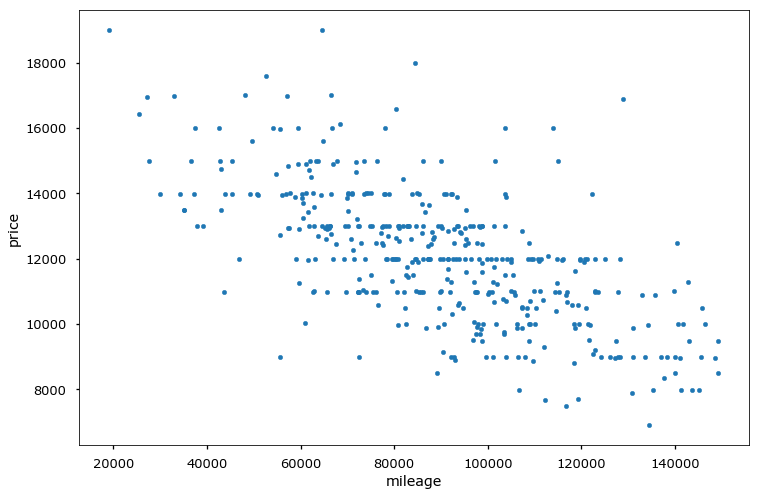

In [4]:
df_auto.plot(x='mileage', y='price', kind='scatter')

In [5]:
from sklearn.linear_model import LinearRegression
X = df_auto.loc[:,['mileage']].values
y = df_auto.loc[:, 'price'].values

model = LinearRegression()
model.fit(X, y)
print('price = {:.2f} {:.2f}*mileage'.format(model.intercept_, model.coef_[0]))

price = 16762.02 -0.05*mileage


In [6]:
df_auto.loc[:, 'kilometerage'] = df_auto.loc[:,'mileage'] * 1.60934
X = df_auto.loc[:,['mileage', 'kilometerage']].values
y = df_auto.loc[:, 'price'].values

model = LinearRegression()
model.fit(X, y)
print('price = {:.2f} {:.2f}*mileage {:.2f}*kilometerage'.format(model.intercept_, *model.coef_))

price = 16762.02 -0.01*mileage -0.02*kilometerage


# Regularization & restrictions

## Intuition

<center><img src=http://www.holehouse.org/mlclass/10_Advice_for_applying_machine_learning_files/Image%20[8].png></center>
[Andrew's Ng Machine Learning Class - Stanford]

## Regularization 

* Insert regularizer $R(\beta)$ for $\beta$ to be small:
$$
\sum_{n=1}^{N}\left(x_{n}^{T}\beta-y_{n}\right)^{2}+\lambda R(\beta)\to\min_{\beta}
$$
* $\lambda>0$ - hyperparameter.
* $R(\beta)$ penalizes complexity of models.
$$
\begin{array}{ll}
R(\beta)=||\beta||_{1} & \mbox{Lasso regression}\\
R(\beta)=||\beta||_{2}^{2} & \text{Ridge regression}
\end{array}
$$

* Not only **accuracy** matters for the solution but also **model simplicity**!
* $\lambda$ controls complexity of the model:$\uparrow\lambda\Leftrightarrow\text{complexity}$$\downarrow$.


## Comments
* Dependency of $\beta$ from $\lambda$ for ridge (A) and LASSO (B):
<center><img src="img/regularization paths.png" width=1500></center>

* LASSO can be used for automatic feature selection.
* $\lambda$ is usually found using cross-validation on exponential grid, e.g. $[10^{-6},10^{-5},...10^{5},10^{6}]$.
* It's always recommended to use regularization because 
    * it gives smooth control over model complexity.
    * reduces ambiguity for multiple solutions case.

<center><img src=img/regul.jpg></center>


In [10]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=1.)

model.fit(X, y)
print('price = {:.2f} {:.2f}*mileage {:.2f}*kilometerage'.format(model.intercept_, *model.coef_))

price = 16762.02 -0.05*mileage -0.00*kilometerage


## ElasticNet
* ElasticNet:

$$
R(\beta)=\alpha||\beta||_{1}+(1-\alpha)||\beta||_{2}^{2}
$$
$\alpha\in(0,1)$ - hyperparameter, controlling impact of each part. 

* If two features $x^{i}$and $x^{j}$ are equal: 
    * LASSO may take only one of them
    * Ridge will take both with equal weight
        * but it doesn't remove useless features
* ElasticNet both removes useless features but gives equal weight for usefull equal features
    * good, because feature equality may be due to chance on this particular training set

## Different account for different features

* Traditional approach regularizes all features uniformly:
$$
\sum_{n=1}^{N}\left(x_{n}^{T}\beta-y_{n}\right)^{2}+\lambda R(\beta)\to\min_{w}
$$
* Suppose we have $K$ groups of features with indices:
$$
I_{1},I_{2},...I_{K}
$$
* We may control the impact of each group on the model by:
$$
\sum_{n=1}^{N}\left(x_{n}^{T}\beta-y_{n}\right)^{2}+\lambda_{1}R(\{\beta_{i}|i\in I_{1}\})+...+\lambda_{K}R(\{\beta_{i}|i\in I_{K}\})\to\min_{w}
$$
* $\lambda_{1},\lambda_{2},...\lambda_{K}$ can be set using cross-validation
* In practice use common regularizer but with different feature scaling.

# Different loss-functions

## Idea
* Generalize squared to arbitrary loss:
$$
\sum_{n=1}^{N}\left(x^{T}\beta-y_{n}\right)^{2}\to\min_{\beta}\qquad\Longrightarrow\qquad\sum_{n=1}^{N}\mathcal{L}(x_{n}^{T}\beta-y_{n})\to\min_{\beta}
$$

$$
\begin{array}{lll}
\textbf{LOSS} & \textbf{NAME} & \textbf{PROPERTIES}\\
\mathcal{L}(\varepsilon)=\varepsilon^{2} & \text{quadratic} & \text{differentiable}\\
\mathcal{L}(\varepsilon)=\left|\varepsilon\right| & \text{absolute} & \text{robust}\\
\mathcal{L}(\varepsilon)=\begin{cases}
\frac{1}{2}\varepsilon^{2}, & \left|\varepsilon\right|\le\delta\\
\delta\left(\left|\varepsilon\right|-\frac{1}{2}\delta\right) & \left|\varepsilon\right|>\delta
\end{cases} & \text{Huber} & \text{differentiable, robust}
\end{array}
$$

* Robust means solution is robust to outliers in the training set.


<center><img src="img/Loss functions.png"></center>

# Weighted account for observations

## Weighted account for observation

Weighted account for observations
$$
\sum_{n=1}^{N}w_{n}(x_{n}^{T}\beta-y_{n})^{2}
$$

* Weights may be:
* increased for incorrectly predicted objects 
    * algorithm becomes more oriented on error correction
* decreased for incorrectly predicted objects 
    * they may be considered outliers that break our model

## Solution for weighted regression

$$
\sum_{n=1}^{N}w_{n}\left(x_{n}^{T}\beta-y_{n}\right)^{2}\to\min_{\beta\in\mathbb{R}}
$$

Stationarity condition:
$$
\sum_{n=1}^{N}w_{n}x_{n}^{d}\left(x_{n}^{T}\beta-y_{n}\right)=0
$$

Define $\{X\}_{n,d}=x_{n}^{d}$, $W=diag\{w_{1},...x_{N}\}$. Then

$$
X^{T}W\left(X\beta-y\right)=0
$$
$$
\beta=\left(X^{T}WX\right)^{-1}X^{T}Wy
$$

## Robust regression

* Initialize $w_{1}=...=w_{N}=1/N$

* Repeat:
    * estimate regression $\widehat{y}(x)$ using observations $(x_{i},y_{i})$ with weights $w_{i}$.
    * for each $i=1,2,...N$:
        * calculate $\varepsilon_{i}=\widehat{y}(x_{i})-y_{i}$
        * calculate $w_{i}=K\left(\left|\varepsilon_{i}\right|\right)$ 
    * normalize weights $w_{i}=\frac{w_{i}}{\sum_{n=1}^{N}w_{n}}$

**Comments:** $K(\cdot)$ is some *decreasing* function, repetition may be 
* predefined number of times
* until convergence of model parameters.

## Example

<center><img src="img/data with outliers.png"></center>

# Linear Classification (in general)

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg/512px-Svm_separating_hyperplanes_%28SVG%29.svg.png'></center>

$$w_1x_1 + w_2x_2 + w_0 = w^{T}x+w_{0}=0$$
$$ y \in \{-1,+1\}$$

## Analytical geometry reminder

## Reminder

* $a=[a^{1},...a^{D}]^{T},\,b=[b^{1},...b^{D}]^{T}$
* Scalar product $\langle a,b\rangle=a^{T}b=\sum_{d=1}^{D}a_{d}b_{b}$ 
* $a\perp b$ means that $\langle a,b\rangle=0$
* Norm $\left\lVert a\right\rVert =\sqrt{\langle a,a\rangle}$
* Distance $\rho(a,b)=\left\lVert a-b\right\rVert =\sqrt{\langle a-b,a-b\rangle}$


<center><img src="img/projection.png"></center>

* $p=\langle a,\frac{b}{\left\lVert b\right\rVert }\rangle$
* $\left|p\right|=\left|\langle a,\frac{b}{\left\lVert b\right\rVert }\rangle\right|$-
unsigned projection length


## Orthogonal vector to hyperplane

### Theorem 1
Vector $w$ is orthogonal to hyperplane $w^{T}x+w_{0}=0$

**Proof:**
Consider arbitrary $x_{A},x_{B}\in\{x:\,w^{T}x+w_{0}=0\}$:
$$
\begin{align}
w^{T}x_{A}+w_{0}=0 \quad \text{   (1)}\\
w^{T}x_{B}+w_{0}=0 \quad \text{   (2)}
\end{align}
$$
By substracting (2) from (1), obtain $w^{T}(x_{A}-x_{B})=0$,
so $w$ is orthogonal to hyperplane.


<center><img src='img\Linear discriminant function 2.png'></center>

## Distance from point to hyperplane

### Theorem 2
Distance from point $x$ to hyperplane
$w^{T}x+w_{0}=0$ is equal to $\frac{w^{T}x+w_{0}}{\left\lVert w\right\rVert }$.

**Proof:** Project $x$ on the hyperplane, let the projection
be $p$ and complement $h=x-p$, orthogonal to hyperplane. Then
$$
x=p+h
$$

Since $p$ lies on the hyperplane, 
$$
w^{T}p+w_{0}=0
$$

Since $h$ is orthogonal to hyperplane and according to theorem 1
$$
h=r\frac{w}{\left\lVert w\right\rVert },\,r\in\mathbb{R}\text{ - distance to hyperplane}.
$$

## Distance from point to hyperplane

$$
x=p+r\frac{w}{\left\lVert w\right\rVert }
$$

After multiplication by $w$ and addition of $w_{0}$:
$$
w^{T}x+w_{0}=w^{T}p+w_{0}+r\frac{w^{T}w}{\left\lVert w\right\rVert }=r\left\lVert w\right\rVert 
$$

because $w^{T}p+w_{0}=0$ and $\left\lVert w\right\rVert =\sqrt{w^{T}w}$.
So we get, that 
$$
r=\frac{w^{T}x+w_{0}}{\left\lVert w\right\rVert }
$$

**Comments:**
* From one side of hyperplane $r>0\Leftrightarrow w^{T}x+w_{0}>0$
* From the other side $r<0\Leftrightarrow w^{T}x+w_{0}<0$. 
* Distance from hyperplane to origin 0 is $\frac{w_{0}}{\left\lVert w\right\rVert }$.
So $w_{0}$ accounts for hyperplane offset.

## Binary linear classifier geometric interpretation

Binary linear classifier:
$$
\widehat{y}(x)= sign\left(w^{T}x+w_{0}\right)
$$

divides feature space by hyperplane $w^{T}x+w_{0}=0$.

* Confidence of decision is proportional to distance to hyperplane $\frac{\left|w^{T}x+w_{0}\right|}{\left\lVert w\right\rVert }$.
* $w^{T}x+w_{0}$ is the confidence that class is positive.


Consider the foolowing objects

| x1 | x2 |
|---|---|
| 0 | 1 |
| 1 | 0 |
| 1 | 1 |
| 2 | 2 |
| 2 | 3 |
| 3 | 2 |

Find class prediction if $(w_0 = -0.3 , w_1 = 0.1, w_2 = 0.1)$

## Margin of binary linear classifier

$$
M(x,y) =y\left(w^{T}x+w_{0}\right)
$$

* $ y \in \{-1,+1\}$
* Margin = score, how well classifier predicted true $y$ for object $x$.
* $M(x,y|w)>0$ <=> object $x$ is correctly classified as $y$
    * signs of $w^{T}x+w_{0}$ and $y$ coincide
* $|M(x,y|w)|=\left|w^{T}x+w_{0}\right|$ - confidence of decision
    * proportional to distance from $x$ to hyperplane $w^{T}x+w_{0}=0$.

## Margin

<center><img src="img/Different margin objects.png"></center>

## Misclassification rate optimization

* Misclassification rate optimization:
$$
\frac{1}{N}\sum_{n=1}^{N}\mathbb{I}[M(x_{n},y_{n}|w)<0]\to\min_{w}
$$



is not recommended:
* discontinious function, can't use numerical optimization!
* continous margin is more informative than binary error indicator.

* If we select loss function $\mathcal{L}(M)$ such that $\mathbb{I}[M]\le\mathcal{L}(M)$
then we can optimize upper bound on misclassification rate:
$$
\begin{gathered}\begin{gathered}\text{MISCLASSIFICATION RATE}\end{gathered}
=\frac{1}{N}\sum_{n=1}^{N}\mathbb{I}[M(x_{n},y_{n}|w)<0]\\
\le\frac{1}{N}\sum_{n=1}^{N}\mathcal{L}(M(x_{n},y_{n}|w))=L(w)
\end{gathered}
$$


## Weights optimization
* Margin = score, how well classifier predicted true $y$ for object $x$.
* Task: select such $w$ to increase $M(x_{n},y_{n}|w)$ for all $n$. 
* Formalization:
$$
\frac{1}{N}\sum_{n=1}^{N}\mathcal{L}\left(M(x_{n},y_{n}|w)\right)\to\min_{w}
$$

## Common loss functions

<center><img src="img/Error indicator approximations.png"></center>

# Optimization

Same story as in linear regression

# Regularization

Same story as in linear regression

<center><img src='img/overfitting.jpg'></center>

## $L_{1}$ regularization


* $||w||_{1}$ regularizer should do feature selection.

* Consider 
$$
L(w)=\sum_{n=1}^{N}\mathcal{L}\left(M(x_{n},y_{n}|w)\right)+\lambda\sum_{d=1}^{D}|w_{d}|
$$

* And gradient updates
$$
\frac{\partial}{\partial w_{i}}L(w)=\sum_{n=1}^{N}\frac{\partial}{\partial w_{i}}\mathcal{L}\left(M(x_{n},y_{n}|w)\right)+\lambda sign (w_{i})
$$

$$
\lambda sign (w_{i})\nrightarrow0\text{ when }w_{i}\to0
$$


## $L_{2}$ regularization

$$
L(w)=\sum_{n=1}^{N}\mathcal{L}\left(M(x_{n},y_{n}|w)\right)+\lambda\sum_{d=1}^{D}w_{d}^{2}
$$

$$
\frac{\partial}{\partial w_{i}}L(w)=\sum_{n=1}^{N}\frac{\partial}{\partial w_{i}}\mathcal{L}\left(M(x_{n},y_{n}|w)\right)+2\lambda w_{i}
$$
$$
2\lambda w_{i}\to0\text{ when }w_{i}\to0
$$

* Strength of regularization $\to0$ as weights $\to0$.
* So $L_{2}$ regularization will not set weights exactly to 0.

# Logistic Regression

## Binary classification

* Linear classifier:
$$
score(\omega_{1}|x)=w^{T}x + w_0 = g(x)
$$
* +relationship between score and class probability is assumed:
$$
p(\omega_{1}|x)=\sigma(w^{T}x + w_0)
$$

where $\sigma(z)=\frac{1}{1+e^{-z}}$ - sigmoid function


In [8]:
def demo_sigmoid():
    z = np.linspace(-10, 10, 100)

    y = sigmoid(z)
    plt.plot(z, y)
    plt.xlabel('$z$')
    plt.ylabel('$\sigma(z)$')
    
def sigmoid(z): 
    return 1./(1+np.exp(-z))

In [ ]:

demo_sigmoid() 

## Binary classification: estimation

* Given our assumption:
    * $p(y=+1|x)=\sigma(w^{T}x + w_0)$
    * $p(y=-1|x)=1 - p(y=+1|x)$
* we can write down Likelihood function:
$$ \mathcal{L}(w) = \prod_{n=1}^N p(y_n=+1|x_n)^{\mathbb{I}[y_n = +1]} p(y_n=-1|x_n)^{\mathbb{I}[y_n = -1]} \rightarrow \max_w$$

* Get rid if products:
$$ -\ln{\mathcal{L}(w)} = - \sum_{n=1}^N \mathbb{I}[y_n = +1]\cdot\ln{\sigma(w^{T}x_n+w_0))} + \mathbb{I}[y_n = -1]\cdot\ln{(1-\sigma(w^{T}x_n+w_0))} \rightarrow \min_w$$
$$L(w) = -\ln{\mathcal{L}(w)} \rightarrow \min_w $$

* Function $L(w)$ is also called log-loss

<center><img src='img/prob.png' width=600></center>

## Another formulation

Using the property $1-\sigma(z)=\sigma(-z)$ obtain that 
$$
p(y=+1|x)=\sigma(w^{T}x+w_0)\Longrightarrow p(y=-1|x)=\sigma(-w^{T}x - w_0)
$$

So for $y\in\{+1,-1\}$
$$
p(y|x)=\sigma(y(\langle w,x\rangle + w_0)) 
$$

Therefore ML estimation can be written as:
$$
\prod_{n=1}^{N}\sigma( y_{n}(\langle w,x_{n}\rangle + w_0))\to\max_{w}
$$

## Loss function for 2-class logistic regression

For binary classification $p(y|x)=\sigma(y(\langle w,x\rangle + w_0))$

Estimation with ML:

$$
\prod_{n=1}^{N}\sigma(y_n(\langle w,x_n\rangle + w_0)) = \prod_{n=1}^{N}\sigma(y_n g(x_n)) = \to\max_{w}
$$

which is equivalent to 
$$
\sum_{n=1}^{N}\ln(1+e^{-y_ng(x_n)})\to\min_{w}
$$

It follows that logistic regression is linear discriminant
estimated with loss function $\mathcal{L}(M)=\ln(1+e^{-M})$.

<center><img src="img/Logistic loss function.png"></center>


# Multiclass classification with binary classifiers

## Multiclass classification with binary classifiers
* Task - make $C$-class classification using many binary classifiers.
* Approaches:

    * **one-versus-all**
        * for each $c=1,2,...C$ train binary classifier on all objects and output $\mathbb{I}[y_{n}=c]$, 
        * assign class, getting the highest score in resulting $C$ classifiers.

    * **one-versus-one**
        * for each $i,j\in[1,2,...C],$ $i\ne j$ learn on objects with $y_{n}\in\{i,j\}$ with output $y_{n}$
        * assign class, getting the highest score in resulting $C(C-1)/2$ classifiers.
        

## Binary linear classifier

* For two classes $y\in\{+1,-1\}$ classifier becomes
$$
\widehat{y}(x)=\begin{cases}
+1, & w_{+1}^{T}x+w_{+1,0}>w_{-1}^{T}x+w_{-1,0}\\
-1 & \text{otherwise}
\end{cases}
$$
* This decision rule is equivalent to 
$$
\begin{align*}
\widehat{y}(x) & =sign(w_{+1}^{T}x+w_{+1,0}-w_{-1}^{T}x+w_{-1,0})=\\
 & =sign\left(\left(w_{+1}^{T}-w_{-1}^{T}\right)x+\left(w_{+1,0}-w_{-1,0}\right)\right)\\
 & =sign\left(w^{T}x+w_{0}\right)
\end{align*}
$$
for $w=w_{+1}-w_{-1},\,w_{0}=w_{+1,0}-w_{-1,0}$.
* Decision boundary $w^{T}x+w_{0}=0$ is linear.
* Multiclass case can be solved using multiple binary classifiers with one-vs-all, one-vs-one
    * can you imagine faulty situation with those approaches for linear classifiers?

<center><img src='img/one versus all ambiguity.png'></center>


<center><img src='img/one versus one ambiguity.png'></center>

## Linear classifier for multiple classes

* Classification among classes 1,2,...C. 
* Use $C$ discriminant functions $g_{c}(x)=w_{c}^{T}x+w_{c0}$
* Decision rule:
$$
\widehat{y}(x)=\arg\max_{c}g_{c}(x)
$$
* Decision boundary between classes $y=i$ and $y=j$ is linear:
$$
\left(w_{i}-w_{j}\right)^{T}x+\left(w_{i0}-w_{j0}\right)=0
$$
* Decision regions are convex

## Logistic regression for multiple classes

Each class has a set of weights:
$$
\begin{cases}
score(\omega_{1}|x)=w_{1}^{T}x + w_{0,1} \\
score(\omega_{2}|x)=w_{2}^{T}x + w_{0,2}\\
\cdots\\
score(\omega_{C}|x)=w_{C}^{T}x + + w_{0,C}
\end{cases}
$$

+relationship between score and class probability is assumed:

$$
p(\omega_{c}|x)=softmax(\omega_c|W, x)=\frac{exp(w_{c}^{T}x + w_{0,c})}{\sum_{i}exp(w_{i}^{T}x + w_{0,i})}
$$


**Estimation with ML:**
$$
\prod_{n=1}^{N}\prod_{c=1}^{C} softmax(\omega_c|W, x_n)^{\mathbb{I}[y_n = w_c]}
$$

Which would lead us to cross-entropy loss function
$$L(w) = - \sum_{n=1}^N\sum_{c=1}^{C} \mathbb{I}[y_n = w_c]\cdot\ln{\sigma(w_c^{T}x_n+w_{c,0}))}$$

## Summary

* Linear classifier - classifier with linear discriminant functions.
* Binary linear classifier: $\widehat{y}(x)=sign(w^{T}x+w_{0})$.
* Perceptron, logistic, SVM - linear classifiers estimated with different loss functions.
* Weights are selected to minimize total loss on margins.
* Gradient descent iteratively optimizes $L(w)$ in the direction of maximum descent.
* Stochastic gradient descent approximates $\nabla_{w}L$ by averaging
gradients over small subset of objects.
* Regularization gives smooth control over model complexity.
* $L_{1}$ regularization automatically selects features.